We will learn about predicting both attributes, continuous and categorical predictions, in a single forward pass.       

1. Import the relevant packages.

2. Fetch a dataset that contains images of persons, their gender, and age information.

3. Create training and test datasets by performing appropriate pre-processing.

4. Build a model where the following applies:   
   • All the layers of the model remain similar to the models we have built so far, except for the last part.    
   • In the last part, create two separate layers branching out from the preceding layer, where one layer corresponds to age estimation and the other to gender classification.    
   • Ensure that you have different loss functions for each branch of output, as age is a continuous value (requiring an mse or mae loss calculation) and gender is a categorical value (requiring a cross-entropy loss calculation).    
   • Take a weighted summation of age estimation loss and gender classification loss.    
   • Minimize the overall loss by performing backpropagation that optimizes weight values.    

5. Train model and predict on new images.


# 1. Import the relevant packages.

In [94]:
import torch
import numpy as np, cv2, pandas as pd, glob, time, os
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models, datasets

import importlib, GenderAgeEstimation as gae
importlib.reload(gae)

<module 'GenderAgeEstimation' from '/home/onkar/Good/modern-cv-with-pytorch/GenderAgeEstimation.py'>

In [95]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [96]:
train_df = pd.read_csv('data/FairFace/fairface_label_train.csv')
valid_df = pd.read_csv('data/FairFace/fairface_label_val.csv')
print(f'{len(train_df)}, {len(valid_df)}')

86744, 10954


In [97]:
train_df.head(10)

,file,age,gender,race,service_test
0,train/1.jpg,50-59,Male,East Asian,True
1,train/2.jpg,30-39,Female,Indian,False
2,train/3.jpg,3-9,Female,Black,False
3,train/4.jpg,20-29,Female,Indian,True
4,train/5.jpg,20-29,Female,Indian,True
5,train/6.jpg,20-29,Male,White,True
6,train/7.jpg,40-49,Male,Middle Eastern,False
7,train/8.jpg,30-39,Female,Indian,True
8,train/9.jpg,10-19,Male,White,True
9,train/10.jpg,30-39,Male,Middle Eastern,False


In [98]:
valid_df.head(10)

,file,age,gender,race,service_test
0,val/1.jpg,3-9,Male,East Asian,False
1,val/2.jpg,50-59,Female,East Asian,True
2,val/3.jpg,30-39,Male,White,True
3,val/4.jpg,20-29,Female,Latino_Hispanic,True
4,val/5.jpg,20-29,Male,Southeast Asian,False
5,val/6.jpg,30-39,Male,Latino_Hispanic,False
6,val/7.jpg,20-29,Male,Black,True
7,val/8.jpg,3-9,Male,East Asian,False
8,val/9.jpg,20-29,Male,Southeast Asian,False
9,val/10.jpg,3-9,Male,Southeast Asian,False


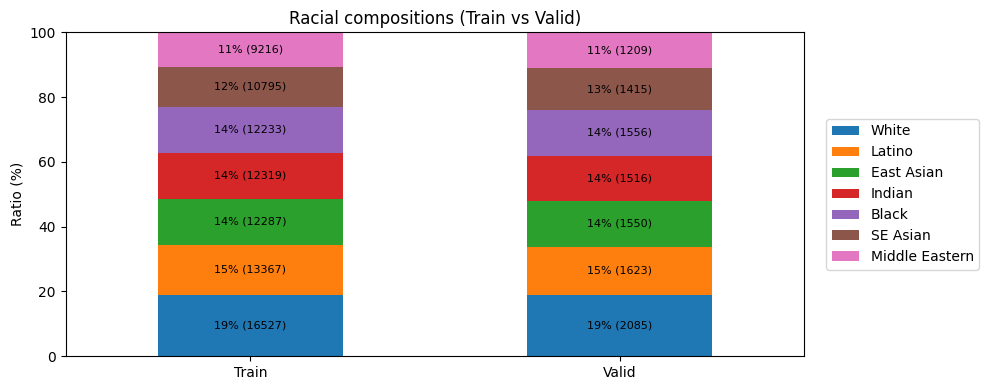

(race       White     Latino  East Asian     Indian      Black   SE Asian  \
 Train  19.052615  15.409711   14.164668  14.201559  14.102416  12.444665   
 Valid  19.034143  14.816505   14.150082  13.839693  14.204857  12.917656   
 
 race   Middle Eastern  
 Train       10.624366  
 Valid       11.037064  ,
 race   White  Latino  East Asian  Indian  Black  SE Asian  Middle Eastern
 Train  16527   13367       12287   12319  12233     10795            9216
 Valid   2085    1623        1550    1516   1556      1415            1209)

In [ ]:
rename_map = {
    "Latino_Hispanic": "Latino",
    "Southeast Asian": "SE Asian",
}

plot_race_composition_with_labels(
    {"Train": train_df, "Valid": valid_df},
    race_col="race",
    rename_map=rename_map,
    title="Racial compositions (Train vs Valid)",
    min_pct_to_label=3.0
)

In [100]:
# pick 1 random image from train + val and print their sizes (H,W,C)

# assumes you already have train_df, valid_df loaded as shown
train_img_rel = train_df.sample(1, random_state=0)["file"].iloc[0]
val_img_rel   = valid_df.sample(1, random_state=0)["file"].iloc[0]

train_img_path = os.path.join("data/FairFace", train_img_rel)
val_img_path   = os.path.join("data/FairFace", val_img_rel)

def print_img_size(path: str):
    img = cv2.imread(path)  # BGR
    if img is None:
        raise FileNotFoundError(f"Could not read: {path}")
    h, w = img.shape[:2]
    c = 1 if img.ndim == 2 else img.shape[2]
    print(f"{path} -> (H,W,C) = ({h},{w},{c})")

print_img_size(train_img_path)
print_img_size(val_img_path)

data/FairFace/train/60377.jpg -> (H,W,C) = (224,224,3)
data/FairFace/val/3990.jpg -> (H,W,C) = (224,224,3)


# 2. Fetch a dataset that contains images of persons, their gender, and age information.

Build the `GenderAgeClass` class that takes a filename as input and returns the corresponding image, gender, and scaled age.

In [101]:
IMAGE_SIZE = 224

class GenderAgeClass(Dataset):
    def __init__(self, df, tfms=None):
        self.df = df
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std =[0.229, 0.224, 0.225]
        )
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, ix):
        f    = self.df.iloc[ix].squeeze()
        file = f.file
        gen  = f.gender == 'Female'
        age  = f.age
        img_path = os.path.join("data/FairFace", file)
        im   = cv2.imread(img_path)
        im   = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        return im, age, gen
    
    def preprocess_image(self, im):
        im = cv2.resize(im, (IMAGE_SIZE, IMAGE_SIZE))
        im = torch.from_numpy(im).permute(2, 0, 1).float() / 255.0
        im = self.normalize(im)
        return im.unsqueeze(0)   # same as im[None]


86744


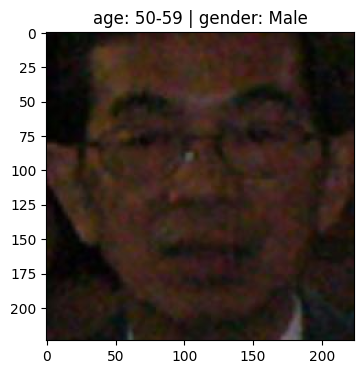

In [102]:
# Test 
train_ds = GenderAgeClass(train_df)
print(len(train_ds))

# pick one sample
ix = 0  # change if you want
im, age, gen = train_ds[ix]

plt.figure(figsize=(4,4))
plt.imshow(im)
plt.axis("on")
plt.title(f"age: {age} | gender: {'Female' if gen else 'Male'}")
plt.show()

In [103]:

import pandas as pd

# 1-Column DataFrame
df = pd.DataFrame({'Target': [10, 20, 30]})

print(df.shape)  # Output: (3, 1) -> It's a table with 1 column
print(type(df))  # Output: <class 'pandas.core.frame.DataFrame'>

# Squeeze it!
squeezed_df = df.squeeze()

print(squeezed_df.shape)  # Output: (3,) -> It's now just a list
print(type(squeezed_df))  # Output: <class 'pandas.core.series.Series'>

(3, 1)
<class 'pandas.core.frame.DataFrame'>
(3,)
<class 'pandas.core.series.Series'>
